In [1]:
import os
import glob
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from keras.utils import load_img
from keras.utils import img_to_array
from keras.models import load_model
from keras.metrics import top_k_categorical_accuracy
from keras.preprocessing.image import ImageDataGenerator

2023-05-31 16:38:08.167056: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
TEST_PATH = "dataset/test/"
TEST_TOP10_PATH = "dataset/test_top10/"
TEST_LAST10_PATH = "dataset/test_last10/"
TEST_DIRS = glob.glob("dataset/test/*")
TEST_TOP10_DIRS = glob.glob("dataset/test_top10/*")
TEST_LAST10_DIRS = glob.glob("dataset/test_last10/*")

MODELS = ["food-seg-103-xception", "food-seg-103-densenet121", "food-seg-103-densenet201"]
CHECKPOINT_PATHS = ["checkpoints/" + MODEL + ".h5" for MODEL in MODELS]
MODEL_PATHS = ["models/" + MODEL + ".h5" for MODEL in MODELS]

IMAGE_SIZE = 512

In [3]:
def acc_top5(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=5)

In [4]:
def load_models():
    loaded_models = []
    for CHECKPOINT_PATH in CHECKPOINT_PATHS:
        loaded_models.append(load_model(CHECKPOINT_PATH, custom_objects={"acc_top5": acc_top5}))
    print("Models Loaded")
    return loaded_models

In [5]:
models = load_models()

Models Loaded


In [6]:
test_datagen = ImageDataGenerator(rescale=1/255)
test_data = test_datagen.flow_from_directory(
    TEST_TOP10_PATH,
    batch_size=1,
    shuffle=False,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    class_mode="categorical")
filenames = test_data.filenames

Found 3375 images belonging to 104 classes.


In [7]:
def evaluate(model):
    test_score = model.evaluate(test_data)
    print("Test Loss: ", test_score[0])
    print("Test Accuracy: ", test_score[1])
    print("Test Accuracy Top 5: ", test_score[2])

In [8]:
for i, model in enumerate(models):
    print("=" * 100)
    print(MODELS[i])
    evaluate(model)
    print("=" * 100)

food-seg-103-xception


2023-05-31 16:38:35.935557: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


3375/3375 [==============================] - 1079s 319ms/step - loss: 1.1655 - accuracy: 0.6673 - acc_top5: 0.9206
Test Loss:  1.165530800819397
Test Accuracy:  0.6672592759132385
Test Accuracy Top 5:  0.9205926060676575
food-seg-103-densenet121


2023-05-31 16:56:34.688810: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


3375/3375 [==============================] - 1498s 443ms/step - loss: 1.2586 - accuracy: 0.6326 - acc_top5: 0.9070
Test Loss:  1.25856351852417
Test Accuracy:  0.6325926184654236
Test Accuracy Top 5:  0.9069629907608032
food-seg-103-densenet201


2023-05-31 17:21:32.500601: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


3375/3375 [==============================] - 2607s 771ms/step - loss: 1.1051 - accuracy: 0.6803 - acc_top5: 0.9265
Test Loss:  1.1051424741744995
Test Accuracy:  0.6802963018417358
Test Accuracy Top 5:  0.9265184998512268


In [9]:
def predict(model):
    predicted_class_indices = []

    with tqdm(total=len(test_data.filepaths)) as pbar:
        for i, filepath in enumerate(test_data.filepaths):
            pbar.set_description("Predicting: %d" % (1 + i))
            pbar.update(1)
            test_image = load_img(filepath, target_size=(IMAGE_SIZE, IMAGE_SIZE))
            test_image_array = img_to_array(test_image)
            test_image_array = np.expand_dims(test_image_array, axis=0)
            test_image_array = test_image_array / 255.
            prediction = model.predict(test_image_array, verbose=0)
            predicted_label = np.argmax(prediction)
            predicted_class_indices.append(predicted_label)
    
    predicted_class_indices = np.asarray(predicted_class_indices)

    predicted_classnames = []
    true_classnames = []
    for i in range(len(filenames)):
        predicted_classnames.append(list(test_data.class_indices.keys())[predicted_class_indices.item(i)])
        true_classnames.append(list(test_data.class_indices.keys())[test_data.labels[i]])
    return pd.DataFrame({"Filename": filenames, "Prediction": predicted_classnames, "True": true_classnames})

In [10]:
results = []
for model in models:
    results.append(predict(model))

Predicting: 3375: 100%|█████████████████████| 3375/3375 [42:36<00:00,  1.32it/s]


In [11]:
mismatched_results = []
for i, result in enumerate(results):
    test_accuracy = result.loc[(result["Prediction"] == result["True"])].shape[0] / result.shape[0]
    mismatched_result = result.loc[~(result["Prediction"] == result["True"])]
    mismatched_results.append(mismatched_result)
    print(MODELS[i] + ": " + "Test Accuracy: " + str(test_accuracy) + ", Mismatch: " + str(len(mismatched_result)))

food-seg-103-xception: Test Accuracy: 0.6672592592592592, Mismatch: 1123
food-seg-103-densenet121: Test Accuracy: 0.6325925925925926, Mismatch: 1240
food-seg-103-densenet201: Test Accuracy: 0.6802962962962963, Mismatch: 1079


In [12]:
results[0].sample(10)

,Filename,Prediction,True
1340,chicken duck/00005501.png,potato,chicken duck
2313,potato/00005959.png,potato,potato
1001,carrot/00005777.png,carrot,carrot
1754,cilantro mint/00006923.png,cilantro mint,cilantro mint
405,bread/00007075.png,potato,bread
2743,steak/00004659.png,steak,steak
749,carrot/00004536.png,carrot,carrot
230,bread/00005494.png,pizza,bread
920,carrot/00005382.png,carrot,carrot
2091,potato/00004629.png,potato,potato


In [ ]:
plt.figure(figsize=(10, 9))

for idx, row in results[0].sample(9).reset_index(drop=True).iterrows():
    plt.subplot(3, 3, idx + 1)
    img = plt.imread(TEST_TOP10_PATH + row["Filename"])
    plt.title("Prediction: " + row["Prediction"] + "\nTrue: " + row["True"])
    plt.imshow(img, cmap="gray")
    plt.axis("off")

plt.tight_layout()

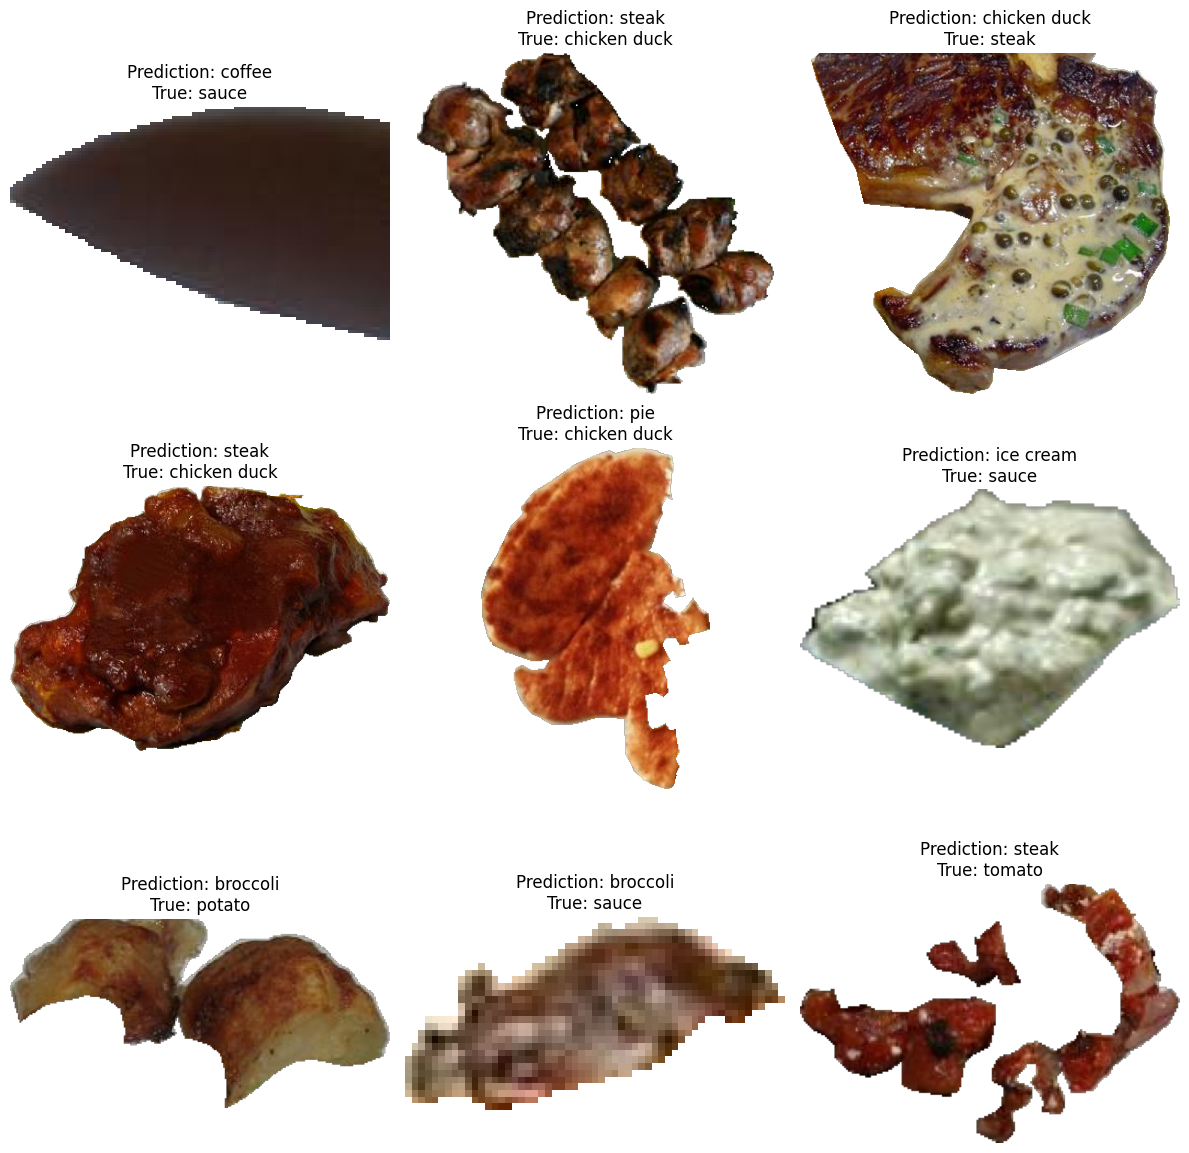

In [14]:
plt.figure(figsize=(12, 12))

for idx, row in mismatched_results[0].sample(9).reset_index(drop=True).iterrows():
    plt.subplot(3, 3, idx + 1)
    img = plt.imread(TEST_TOP10_PATH + row["Filename"])
    plt.title("Prediction: " + row["Prediction"] + "\nTrue: " + row["True"])
    plt.imshow(img, cmap="gray")
    plt.axis("off")

plt.tight_layout()

In [15]:
ensemble_result = {}
for i, result in enumerate(results):
    ensemble_result[i] = result["Prediction"]
ensemble_result["True"] = results[0]["True"]
ensemble_result = pd.DataFrame(ensemble_result)
ensemble_result.sample(10)

,0,1,2,True
367,cheese butter,onion,cheese butter,bread
2270,potato,ice cream,cauliflower,potato
2772,steak,sausage,lettuce,steak
3345,tomato,tomato,tomato,tomato
646,broccoli,broccoli,broccoli,broccoli
902,carrot,carrot,carrot,carrot
1756,cilantro mint,cilantro mint,cilantro mint,cilantro mint
1246,chicken duck,chicken duck,steak,chicken duck
847,carrot,carrot,tomato,carrot
2713,sauce,pork,steak,steak


In [16]:
def get_ensemble_result():
    truth = 0
    for index, row in ensemble_result.iterrows():
        predictions = list(row)[:-1]
        prediction = max(set(predictions), key=predictions.count)
        label = list(row)[-1:][0]
        if prediction == label:
            truth += 1
    return truth / ensemble_result.shape[0]

In [17]:
print("Ensemble Test Accuracy: " + str(get_ensemble_result()))

Ensemble Test Accuracy: 0.7013333333333334
